In [1]:
import sys  
sys.path.insert(0, '/Users/tliaudat/Documents/PhD/codes/WF_PSF/')

import numpy as np
import scipy.signal as spsig
import scipy.interpolate as sinterp
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
import PIL
import time
from tqdm import tqdm


%pylab inline

# Pre-defined colormap
top = mpl.cm.get_cmap('Oranges_r', 128)
bottom = mpl.cm.get_cmap('Blues', 128)
newcolors = np.vstack((top(np.linspace(0, 1, 128)),
                       bottom(np.linspace(0, 1, 128))))
newcmp = ListedColormap(newcolors, name='OrangeBlue')

# Import from the wf-psf module
from py_code.SimPSFToolkit import SimPSFToolkit
from py_code.GenFieldPSF import GenFieldPSF

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Pre-defined colormap
top = mpl.cm.get_cmap('Oranges_r', 128)
bottom = mpl.cm.get_cmap('Blues', 128)
newcolors = np.vstack((top(np.linspace(0, 1, 128)),
                       bottom(np.linspace(0, 1, 128))))
newcmp = ListedColormap(newcolors, name='OrangeBlue')

# plt.rc('text', usetex=True)
# font = {'family' : 'serif',
#         'weight' : 'bold',
#         'size'   : 20}
font = {'size'   : 14}
mpl.rc('font', **font)


output_path = './figures/'



In [3]:
# Set parameters
x_lims = [0, 1e3]
y_lims = [0, 1e3]
grid_points = [4, 4] # number of points in x-axis, and in y-axis
d_max = 2
max_order = 45
lim_max_wfe_rms = 0.1

# Choose the anchor points on a regular grid
x = np.linspace(x_lims[0], x_lims[1], num=grid_points[0], endpoint=True)
y = np.linspace(y_lims[0], y_lims[1], num=grid_points[1], endpoint=True)

xv_grid, yv_grid = np.meshgrid(x, y)


In [4]:
# Random position shift
# It is done as a random shift defined in a
# square centred in each grid position so that there is
# no overlaping between the squares.
xv_rand = np.random.rand(grid_points[0], grid_points[1]) 
yv_rand = np.random.rand(grid_points[0], grid_points[1]) 

x_step = (x_lims[1] - x_lims[0]) / grid_points[0]
y_step = (y_lims[1] - y_lims[0]) / grid_points[1]

xv_rand = (xv_rand - 0.5) * x_step
yv_rand = (yv_rand - 0.5) * y_step

# Add the shift to the grid values
xv = xv_grid + xv_rand
yv = yv_grid + yv_rand

# Flatten
xv_flat = xv.flatten()
yv_flat = yv.flatten()

# Check the limits
xv_flat[xv_flat>x_lims[1]] = x_lims[1]
xv_flat[xv_flat<x_lims[0]] = x_lims[0]

yv_flat[yv_flat>y_lims[1]] = y_lims[1]
yv_flat[yv_flat<y_lims[0]] = y_lims[0]




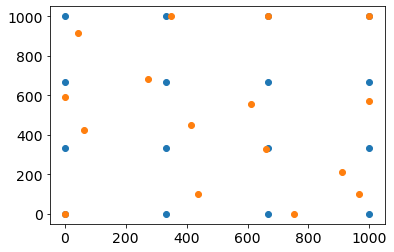

In [5]:
scatter(xv_grid, yv_grid)
scatter(xv_flat.reshape(xv.shape), yv_flat.reshape(yv.shape))
show()


In [6]:
# Select a random vector of size `max_order` for each position
# When concatenated into the Z matrix we have:
Z = np.random.randn(max_order, len(xv_flat))

# Normalize so that each position has the lim_max_wfe_rms
norm_weights = np.sqrt(np.sum(Z**2, axis=1))
Z /= (norm_weights.reshape((-1,1))/ lim_max_wfe_rms)


In [7]:
def poly_mat_gen(xv_flat, yv_flat, d_max, x_lims, y_lims):
    n_mono = (d_max + 1) * (d_max + 2) // 2
    Pi = np.zeros((n_mono, xv_flat.shape[0]))

    # OLD: Scale positions to the square [0,1] x [0,1]
    # Scale positions to the square [-1,1] x [-1,1]
    scaled_x = (xv_flat - x_lims[0]) / (x_lims[1] - x_lims[0])
    scaled_x = (scaled_x - 0.5) * 2
    scaled_y = (yv_flat - y_lims[0]) / (y_lims[1] - y_lims[0])
    scaled_y = (scaled_y - 0.5) * 2

    for d in range(d_max + 1):
        row_idx = d * (d + 1) // 2
        for p in range(d + 1):
            Pi[row_idx + p, :] = scaled_x ** (d - p) * scaled_y ** p
    
    # Normalise
    norm_weights = np.sqrt(np.sum(Pi ** 2, axis=1))
    Pi /= norm_weights.reshape(-1, 1)
    
    return Pi


Pi = poly_mat_gen(xv_flat, yv_flat, d_max, x_lims, y_lims)


In [8]:
# Estimate by least-squares the C matrix
C_poly = Z @ np.linalg.pinv(Pi)

# Re-estimate the Z matrix with the estimated C
Z_hat = C_poly @ Pi

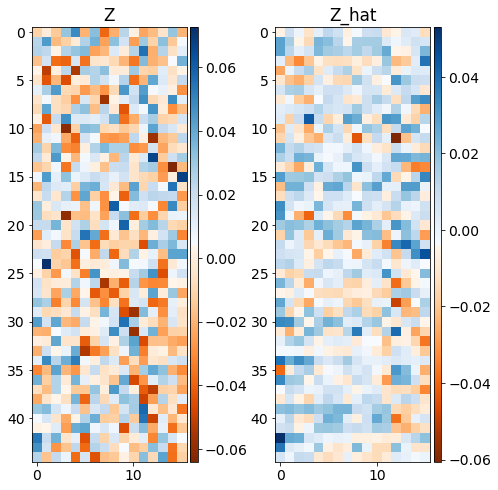

In [9]:
plt.figure(figsize=(8,8))

ax1 =subplot(121)
im1 = plt.imshow(Z, cmap=newcmp)
title('Z')
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
colorbar(im1, cax=cax)

ax2 = subplot(122)
im2 = plt.imshow(Z_hat, cmap=newcmp)
title('Z_hat')
divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="5%", pad=0.05)
colorbar(im2, cax=cax)

show()

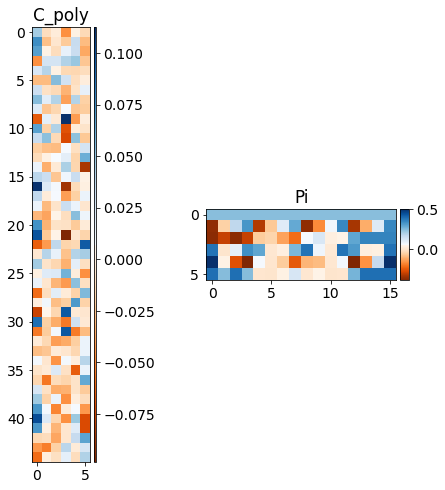

In [10]:
plt.figure(figsize=(8,8))

ax1 =subplot(121)
im1 = plt.imshow(C_poly, cmap=newcmp)
title('C_poly')
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
colorbar(im1, cax=cax)

ax2 = subplot(122)
im2 = plt.imshow(Pi, cmap=newcmp)
title('Pi')
divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="5%", pad=0.05)
colorbar(im2, cax=cax)

show()

In [11]:

def zernike_poly_gen(xv_flat, yv_flat, C_poly, d_max, x_lims, y_lims):
    
    # Generate the polynomial matrix
    Pi_samples = poly_mat_gen(xv_flat, yv_flat, d_max, x_lims, y_lims)
    
    return C_poly @ Pi_samples
    



In [12]:
# Sampling the space
# Choose the anchor points on a regular grid
x = np.linspace(x_lims[0], x_lims[1], num=100, endpoint=True)
y = np.linspace(y_lims[0], y_lims[1], num=100, endpoint=True)
xv_grid, yv_grid = np.meshgrid(x, y)


Z_est = zernike_poly_gen(xv_grid.flatten(), yv_grid.flatten(), C_poly, d_max, x_lims, y_lims)



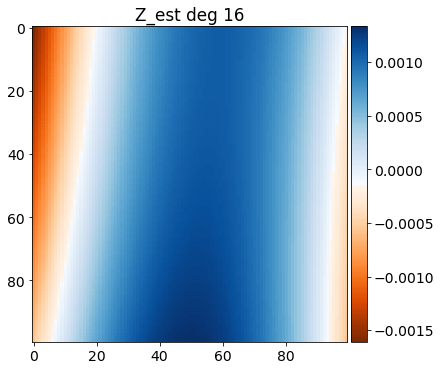

In [13]:
# Check the variations of one zernike polynomial

z_deg = 16

plt.figure(figsize=(6,6))
ax = plt.gca()
im = plt.imshow(Z_est[z_deg,:].reshape(xv_grid.shape), cmap=newcmp)
title('Z_est deg %d'%(z_deg))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
colorbar(im, cax=cax)
show()

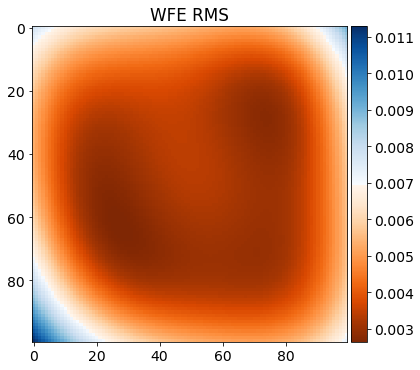

In [14]:
# Check the WFE RMS of the field

calc_wfe = np.sqrt(np.sum(Z_est**2, axis=0))

plt.figure(figsize=(6,6))
ax = plt.gca()
im = plt.imshow(calc_wfe.reshape(xv_grid.shape), cmap=newcmp)
title('WFE RMS')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
colorbar(im, cax=cax)
show()



In [15]:
# We need to renormalize and check that the WFE RMS should have a max value near the expected one :/
# scale the WFE RMS so that its max is the wfe_lim

# Due to the polynomnial behaviour we will set the mean WFE_RMS over the field of view to be 80% of
# the maximum allowed WFE_RMS per position.

# scale_factor = lim_max_wfe_rms/calc_wfe.max()
scale_factor = (0.8*lim_max_wfe_rms)/np.mean(calc_wfe)
scaled_C_poly = C_poly * scale_factor



In [16]:
# Recalculate the Z coefficients
scaled_Z_est = zernike_poly_gen(xv_grid.flatten(), yv_grid.flatten(), scaled_C_poly, d_max, x_lims, y_lims)




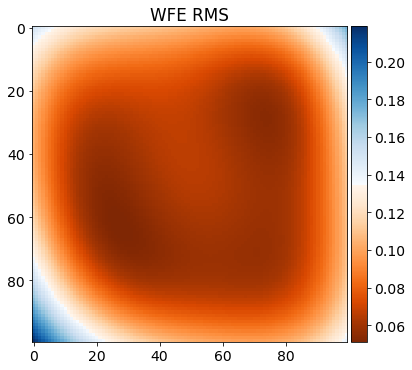

In [17]:
# Check the WFE RMS of the field

scaled_calc_wfe = np.sqrt(np.sum(scaled_Z_est**2, axis=0))

plt.figure(figsize=(6,6))
ax = plt.gca()
im = plt.imshow(scaled_calc_wfe.reshape(xv_grid.shape), cmap=newcmp)
title('WFE RMS')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
colorbar(im, cax=cax)
show()